# Deep Neural Collaborative Filtering

Use concatenate and dot product to build the deep recommender model

In [14]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [19]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item, random_split, user_split

In [20]:
%matplotlib inline

### Prepare the data

In [21]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items = pd.read_csv("data/items.csv")

In [22]:
# Data Encoding
DATA, user_encoder, item_encoder = encode_user_item(df_ratings, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [23]:
DATA.head()

,user_id,movie_id,RATING,TIMESTAMP,USER,ITEM
0,196,242,3,881250949,195,241
1,186,302,3,891717742,185,301
2,22,377,1,878887116,21,376
3,244,51,2,880606923,243,50
4,166,346,1,886397596,165,345


In [24]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1682)

In [25]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(1, 5)

In [26]:
# Data Splitting
#train, val, test = user_split(DATA, [0.6, 0.2, 0.2])
train, test = user_split(DATA, [0.8, 0.2])

In [27]:
train.shape, test.shape

((80000, 7), (20000, 7))

## Deep Neural CF

This is a model with both dot and concatenate layers

In [32]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape, Concatenate, Dense
from keras.regularizers import l2
from keras.constraints import non_neg
from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from reco import vis

In [31]:
# !pip3 install altair

### Build the Model

In [33]:
def Neural_CF(n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    
    # Item Embedding MF
    item_embedding_mf = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-6),
                                  embeddings_initializer='he_normal',
                                  name='ItemEmbeddingMF')(item_input)
    item_vec_mf = Flatten(name='FlattenItemMF')(item_embedding_mf)
    
    
    # Item embedding MLP
    item_embedding_mlp = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-6),
                                embeddings_initializer='he_normal',
                               name='ItemEmbeddingMLP')(item_input)
    item_vec_mlp = Flatten(name='FlattenItemMLP')(item_embedding_mlp)
    

    # User Layer
    user_input = Input(shape=[1], name='User')
    
    # User Embedding MF
    user_embedding_mf = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6), 
                                embeddings_initializer='he_normal',
                               name='UserEmbeddingMF')(user_input)
    user_vec_mf = Flatten(name='FlattenUserMF')(user_embedding_mf)
    
    # User Embedding MF
    user_embedding_mlp = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6),
                               embeddings_initializer='he_normal',
                               name='UserEmbeddingMLP')(user_input)
    user_vec_mlp = Flatten(name='FlattenUserMLP')(user_embedding_mlp)
    
    # Multiply MF paths
    DotProductMF = Dot(axes=1, name='DotProductMF')([item_vec_mf, user_vec_mf])
    
    # Concat MLP paths
    ConcatMLP = Concatenate(name='ConcatMLP')([item_vec_mlp, user_vec_mlp])
    
    # Use Dense to learn non-linear dense representation
    Dense_1 = Dense(50, name="Dense1")(ConcatMLP)
    Dense_2 = Dense(20, name="Dense2")(Dense_1)

    # Concatenate MF and MLP paths
    Concat = Concatenate(name="ConcatAll")([DotProductMF, Dense_2])
    
    # Use Dense to learn non-linear dense representation
    Pred = Dense(1, name="Pred")(Concat)
    

    # Item Bias
    item_bias = Embedding(n_items, 1, embeddings_regularizer=l2(1e-5), name='ItemBias')(item_input)
    item_bias_vec = Flatten(name='FlattenItemBiasE')(item_bias)

    # User Bias
    user_bias = Embedding(n_users, 1, embeddings_regularizer=l2(1e-5), name='UserBias')(user_input)
    user_bias_vec = Flatten(name='FlattenUserBiasE')(user_bias)

    # Pred with bias added
    PredAddBias = Add(name="AddBias")([Pred, item_bias_vec, user_bias_vec])
    
    
    # Scaling for each user
    y = Activation('sigmoid')(PredAddBias)
    rating_output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(y)
    
    # Model Creation
    model = Model([user_input, item_input], rating_output)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer="adam")
    
    return model

In [34]:
n_factors = 40
model = Neural_CF(n_users, n_items, n_factors)

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 ItemEmbeddingMLP (Embedding)   (None, 1, 40)        67280       ['Item[0][0]']                   
                                                                                                  
 UserEmbeddingMLP (Embedding)   (None, 1, 40)        37720       ['User[0][0]']                   
                                                                                              

In [36]:
from reco.utils import create_directory
create_directory("/model-img")

Directory already exists C:\Users\Hp\Downloads\recommendation\MovieLens/model-img


In [41]:
plot_model(model, show_layer_names=True, show_shapes=True, to_file="model-img/Neural-CF.png" )

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [38]:
# !pip3 install pydot

  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)


In [39]:
# !pip3 install graphviz

### Train the Model

In [42]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
500/500 [==============================] - 2s 2ms/step - loss: 0.9819 - val_loss: 1.0105
Epoch 2/5
500/500 [==============================] - 1s 2ms/step - loss: 0.8695 - val_loss: 1.0051
Epoch 3/5
500/500 [==============================] - 1s 2ms/step - loss: 0.7180 - val_loss: 1.0088
Epoch 4/5
500/500 [==============================] - ETA: 0s - loss: 0.504 - 1s 2ms/step - loss: 0.5044 - val_loss: 1.0100
Epoch 5/5
500/500 [==============================] - 1s 2ms/step - loss: 0.3715 - val_loss: 1.0093
Wall time: 6.43 s


In [43]:
vis.metrics(output.history)

alt.FacetChart(...)

### Score the Model

In [44]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

625/625 [==============================] - 1s 1ms/step - loss: 0.9886


0.9885789155960083

### Evaluate the Model

In [45]:
from reco.evaluate import get_embedding, get_predictions, recommend_topk
from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [46]:
item_embedding_mf = get_embedding(model, "ItemEmbeddingMF")
user_embedding_mf = get_embedding(model, "UserEmbeddingMF")
item_embedding_mlp = get_embedding(model, "ItemEmbeddingMLP")
user_embedding_mlp = get_embedding(model, "UserEmbeddingMLP")

In [47]:
item_embedding = np.mean([item_embedding_mf,item_embedding_mlp], axis=0)
user_embedding = np.mean([user_embedding_mf,user_embedding_mlp], axis=0)

In [48]:
%%time
predictions = get_predictions(model, DATA)

Wall time: 44.6 s


In [49]:
predictions.head()

,USER,ITEM,RATING_PRED
0,195,241,2.930985
1,195,301,3.620837
2,195,376,2.230920
3,195,50,3.571694
4,195,345,3.294135


In [50]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

Wall time: 48.5 s


In [51]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.061484
Precision@K:	0.044857
Recall@K:	0.020850


### Get Similar Items

In [52]:
from reco.recommend import get_similar, show_similar

In [53]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

Wall time: 213 ms


In [54]:
item_similar_indices

array([[   0, 1250,  607, 1085,  816],
       [   1, 1518, 1408, 1541, 1031],
       [   2, 1089,  786, 1497, 1452],
       ...,
       [1679, 1668, 1563, 1681, 1550],
       [1680, 1566, 1672, 1563, 1668],
       [1681, 1563, 1550, 1668, 1672]], dtype=int64)

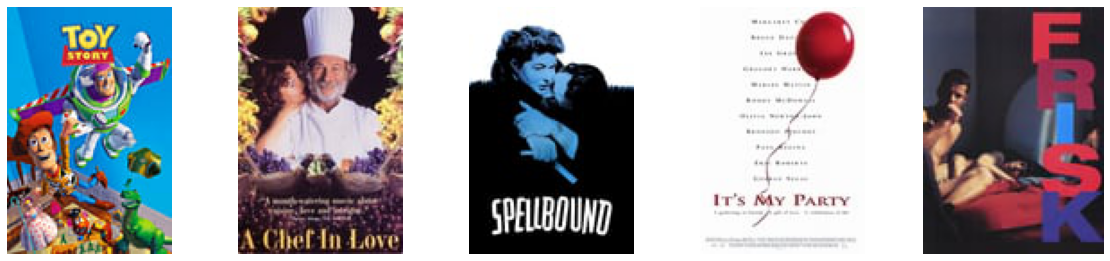

In [56]:
show_similar(0, item_similar_indices, item_encoder)